In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.io import loadmat
from scipy.stats import multivariate_normal

np.random.seed(42)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Q2
## Implementing EM for MNIST dataset, with PCA for dimensionality reduction.

Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset.
We reduce the dataset to be only two cases, of digits “2” and “6” only. Thus, you will fit
GMM with C = 2. Use the data file data.mat or data.dat. True label of the data are also
provided in label.mat and label.dat
The matrix images is of size 784-by-1990, i.e., there are totally 1990 images, and each
column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized;
the original image can be recovered by map the vector into a matrix).
First use PCA to reduce the dimensionality of the data before applying to EM. We will
put all “6” and “2” digits together, to project the original data into 5-dimensional vectors.
Now implement EM algorithm for the projected data (with 5-dimensions).

#### 1. Select from data one raw image of “2” and “6” and visualize them, respectively.

In [2]:
data = loadmat('data.mat')['data'].T
labels = loadmat('label.mat')['trueLabel'].T

In [3]:
two = data[0, :]
six = data[-1, :]

orig_shape = (28,28)

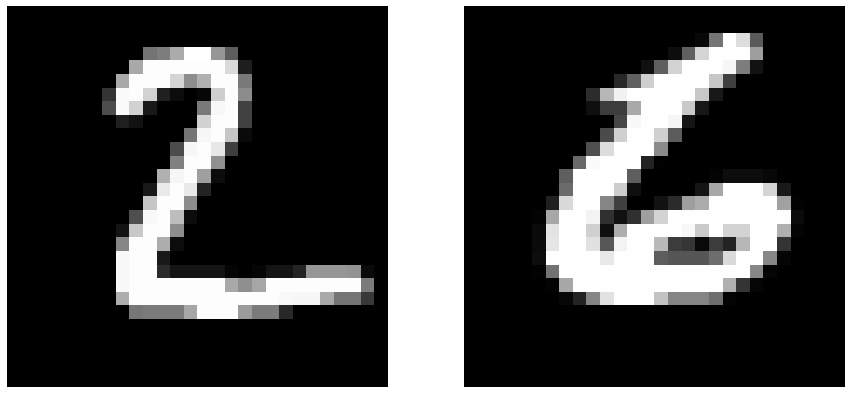

In [4]:
plt.subplots(nrows=1, ncols=2, figsize=(15,8))
plt.subplot(121)
plt.imshow(two.reshape(orig_shape).T, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(six.reshape(orig_shape).T, cmap='gray')
plt.axis('off')
plt.savefig('numbers.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

#### Write down detailed expression of the E-step and M-step in the EM algorithm (hint: when computing $\tau_k^i$ , you can drop the (2π) n/2 factor from the numerator and denominator expression, since it will be canceled out; this can help avoid some numerical issues in computation).

The data **X** in which the GMM is being fit on, contains 1990 observations, and is decomposed to its first 5 principal components. Therefore:

$$
X \in \mathbb{R}^{1990 x 5}
$$

We are attmepting to fit 2 clusters, representative of the two images classes {2, 6}. Therefore:

$$
\text{# Clusters K} = 2
$$

A single cluster **k**, which is a multivariate guassian $\mathcal{N_k}(\mu_k, \Sigma_k)$, is parameterized by mean $\mu_k$ and covariance matrix $\Sigma_k$. Given the dimension of input data **X**:

$$
\mathcal{N_k}(\mu_k, \Sigma_k) = \frac{exp[\frac{-1}{2}(X - \mu_k)^T \Sigma^{-1} (X-\mu_k)]}{ \sqrt{(2 \pi)^n |\Sigma|} }\ \ \ \ \ \ \ \ \ \ \ \text{(1)}
$$
Where
$$
\mu_k \in \mathbb{R}^{5 x 1}
$$
$$
\Sigma_k \in \mathbb{R}^{5 x 5}
$$


**E-Step (Expectation)**
----------------
The E-Step of the EM algorithm, aims to update the posterior probabilities for each observation with respect to each cluster in **K**. The posterior probability $\tau_k^{(i)}$ is described by:
$$
\tau_k^{(i)} = \frac{ \pi_k \mathcal{N_k}(X^{(i)} | \mu_k, \Sigma_k) }{\sum_{k=1}^{K=2} \pi_k \mathcal{N_k}(X^{(i)} | \mu_k, \Sigma_k) } \ \ \ \ \ \ \ \ \ \ \ \text{(2)}
$$

Where $\pi_k$ is the mixing coefficient for clusteer **k**, $X^{(i)}$ is the $i^{th}$ observation in **X** and $\tau_k^{(i)}$ is the posterior probability that $X^{(i)}$ comes from cluster **k**. Plugging (1) into (2) yields:

$$
\tau_k^{(i)} = \frac{ \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{(2 \pi)^n |\Sigma_k|} }} {\sum_{k=1}^{K=2} \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{(2 \pi)^n |\Sigma_k|} } } \ \ \ \ \ \ \ \ \ \ \text{(3)}
$$

Extracting the constants from the numerator and denominator from (3)

$$
\tau_k^{(i)} = \frac{ \frac{1}{\sqrt{(2 \pi)^n }} \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{|\Sigma_k|} }} { \frac{1}{\sqrt{(2 \pi)^n}}  \sum_{k=1}^{K=2} \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{ |\Sigma_k|} } } 
$$

Cancelling out the constants yields

$$
\boxed{\tau_k^{(i)} = \frac{  \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{|\Sigma_k|} }} {  \sum_{k=1}^{K=2} \pi_k  \frac{exp[\frac{-1}{2}(X^{(i)} - \mu_k)^T \Sigma^{-1}_k (X^{(i)}-\mu_k)]}{ \sqrt{ |\Sigma_k|} } } \ \ \ \ \ \ \ \ \ \ \text{(4)}}
$$

**M-Step (Maximization)**
---------

After calculating the posteriors for each cluster w.r.t to each obseravation in **X**, we update $\pi_k$, $\mu_k$ and $\Sigma_k$ for each cluster with respect to the new densities corresponding to the posteriors calculated in the E-step. The mean for each cluster is updated by:

$$
\mu_k = \frac{\sum_i \tau_k^i X^i  }{ \sum_i \tau_i^k }\ \ \ \ \ \ \ \ \ \ \ \text{(5)}
$$
for (i = 1, 2, 3, .... m). The mixing coefficients are updated by:
$$
\pi_k = \frac{ \sum_i \tau_k^i }{ m  }\ \ \ \ \ \ \ \ \ \ \ \text{(6)}
$$
where m=1990 is the total number of observations in **X**. Finally the covariances for each cluster are updated by:
$$
\Sigma_k = \frac{ \sum_i \tau_k^i (X^i - \mu_k)(X^i - \mu_k)^T }{\sum_i \tau_k^i  } \ \ \ \ \ \ \ \ \ \ \ \text{(7)}
$$

#### 3. Implement EM algorithm yourself. Use the following initialization
* initialization for mean: random Gaussian vector with zero mean
* initialization for covariance: generate two Gaussian random matrix of size n-by- n: $S_1$ and $S_2$ , and initialize the covariance matrix for the two components are $\Sigma_1 = S_1S_1^T + I_n$ , and $\Sigma_2 = S_2S_2^T + I_n$ , where $I_n$ is an identity matrix of size n-by-n.

In [5]:
class GMM:
    def __init__(self, K: int, maxIter: int, tol=1e-3, seed=42, savefig=None) -> None:
        np.random.seed(seed)
        
        #Number of gaussian clusters
        self.K = K
        self.maxIter = maxIter
        self.tol = tol
        self.lls = []
        self.save = savefig
        
    def fit(self, X: np.array):
        
        assert len(X.shape) >= 2, 'If passing a vector of data, ensure two dimensions by reshaping data "X.reshape(-1,1)"'
        #initialize clusters
        self._initialize(X=X)
        
        for i in range(self.maxIter):
            
            print('.........iteration {}.........'.format(i))
            #run the E step
            self._expectation(X)
            
            #run the M step
            self._maximization(X)
            
            diff = np.linalg.norm(self.mus - self.mus_old)

            if np.linalg.norm(self.mus-self.mus_old) < self.tol:
                print('Converged!')
                break
            
            self.mus_old = self.mus.copy()
        
        if i == self.maxIter-1:
            print('Max iterations reached')
            
        plt.figure(figsize=(25,10))
        plt.plot(self.lls, ls='--', lw=3)
        plt.scatter(range(len(self.lls)), self.lls, marker='o', edgecolor='k', s=200, color='gray',zorder=3)
        plt.grid()
        plt.xlabel('Iterations', fontsize=20)
        plt.ylabel('Log Likelihood', fontsize=20)
        if self.save:
            plt.savefig(self.save, bbox_layout='tight', bbox_inches='tight')
        plt.show()
    
    def _initialize(self, X):
        #get shape of the data
        m,n = X.shape
        
        #initialize K-gaussian clusters with mean randomly sampled from 0 centered Gaussian
        self.mus = np.random.randn(self.K, n)
        self.mus_old = self.mus.copy()
        
        #initialize K-covariance matrices
        self.covs = []
        for _ in range(self.K):
            S = np.random.randn(n,n)
            S = S@S.T + np.eye(n)
            self.covs.append(S)

        
        #initialize priors
        self.pis = np.random.random(self.K)
        self.pis = self.pis / np.sum(self.pis)
        
        #initialize the posterior
        self.tau = np.full((m,self.K), fill_value=0.)
        
    def _expectation(self, X: np.array):
        
        for i in range(self.K):
            self.tau[:, i] = self.pis[i] * multivariate_normal.pdf(X, 
                                                                   self.mus[i], 
                                                                   self.covs[i])
        #normalize tau
        sum_tau = np.sum(self.tau, axis=1).reshape(-1,1)
        self.tau = np.divide(self.tau, np.tile(sum_tau, (1,self.K)))
        
        #calculate log-likelihood
        ll = np.sum(np.log(sum_tau))
        self.lls.append(ll)
        
    def _maximization(self, X: np.array):
        
        m,n = X.shape
        
        for i in range(self.K):
            
            #update priors
            self.pis[i] = np.sum(self.tau[:,i]) / m
            
            #update cluster mean
            self.mus[i] = X.T @ self.tau[:, i] / np.sum(self.tau[:,i], axis=0)
            
            #update cluster covariance
            dummy = X - np.tile(self.mus[i], (m,1))
            self.covs[i] = dummy.T @ np.diag(self.tau[:, i]) @ dummy / np.sum(self.tau[:,i], axis=0)

In [6]:
#scale data to first 5 components of PCA
pca = PCA(n_components=5)
data_pca = pca.fit_transform(data)

.........iteration 0.........
.........iteration 1.........
.........iteration 2.........
.........iteration 3.........
.........iteration 4.........
.........iteration 5.........
.........iteration 6.........
.........iteration 7.........
.........iteration 8.........
.........iteration 9.........
.........iteration 10.........
.........iteration 11.........
.........iteration 12.........
Converged!


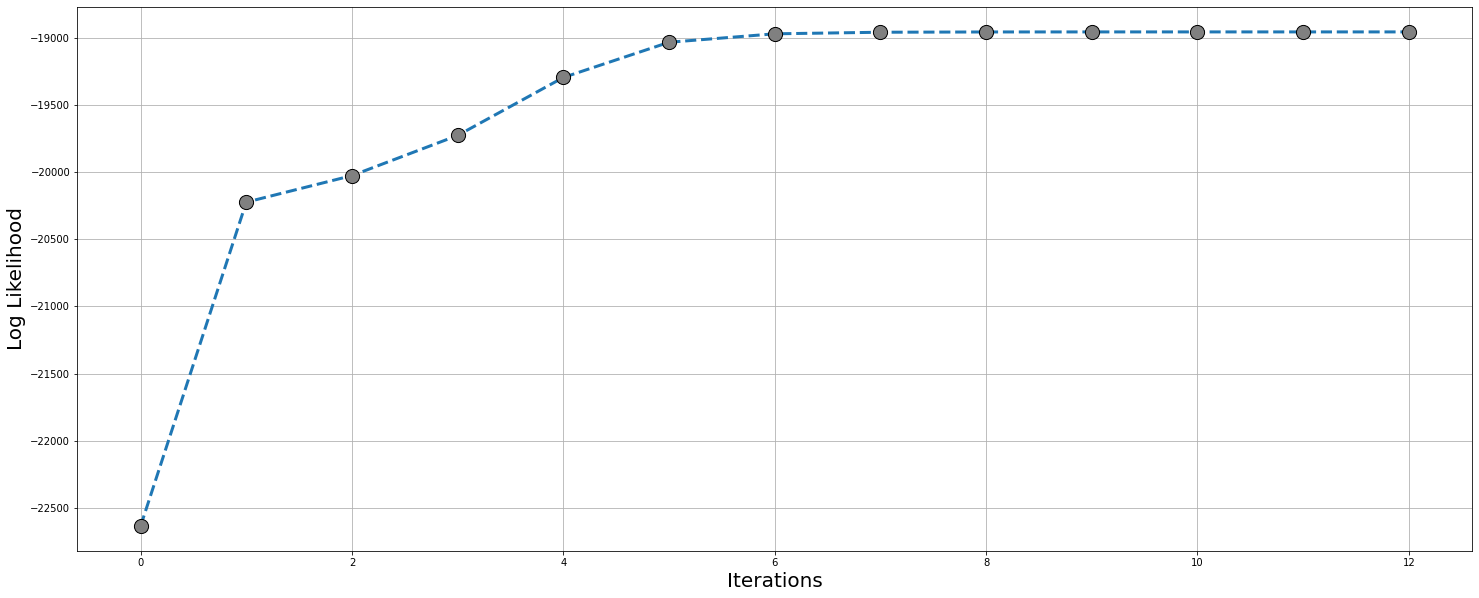

In [7]:
#fit the model
gmm = GMM(K=2, maxIter=100, seed=2000, savefig='ll.png')
gmm.fit(data_pca)

#### 4. Report, the fitted GMM model when EM has terminated in your algorithms as follows. Make sure to report the weights for each component, and the mean of each component (you can reformat the vector to make them into 28-by-28 matrices and show images). Ideally, you should be able to see these means corresponds to “average” images. Report the two 784-by-784 covariance matrices by visualize their intensities.

In [8]:
def reconstruct_mus_and_sigmas(mus, sigmas, savefig1=None, savefig2=None):
    mus = pca.inverse_transform(mus)
    
    plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    plt.subplot(121)
    plt.imshow(mus[0,:].reshape(28,28).T, cmap='gray')
    plt.title('Mean 1', fontsize=18)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Mean 2', fontsize=18)
    plt.imshow(mus[1,:].reshape(28,28).T, cmap='gray')
    plt.axis('off')
    plt.suptitle('Reconstructed Means', fontsize=36)
    if savefig1:
        plt.savefig(savefig1, bbox_inches='tight', bbox_layout='tight')
    plt.show()
    
    
    U = pca.components_.T
    A = np.sqrt(np.diag(pca.singular_values_))
    
    sig1 = sigmas[0]
    sig2 = sigmas[1]
    
    sig1_recon = U@A@sig1@A@U.T
    sig2_recon = U@A@sig2@A@U.T
    
    
    plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    plt.subplot(121)
    plt.imshow(sig1_recon, cmap='gray')
    plt.title('Σ1', fontsize=18)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Σ2', fontsize=18)
    plt.imshow(sig2_recon, cmap='gray')
    plt.axis('off')
    plt.suptitle('Reconstructed Covariances', fontsize=36)
    if savefig2:
        plt.savefig(savefig2, bbox_inches='tight', bbox_layout='tight')
    plt.show()

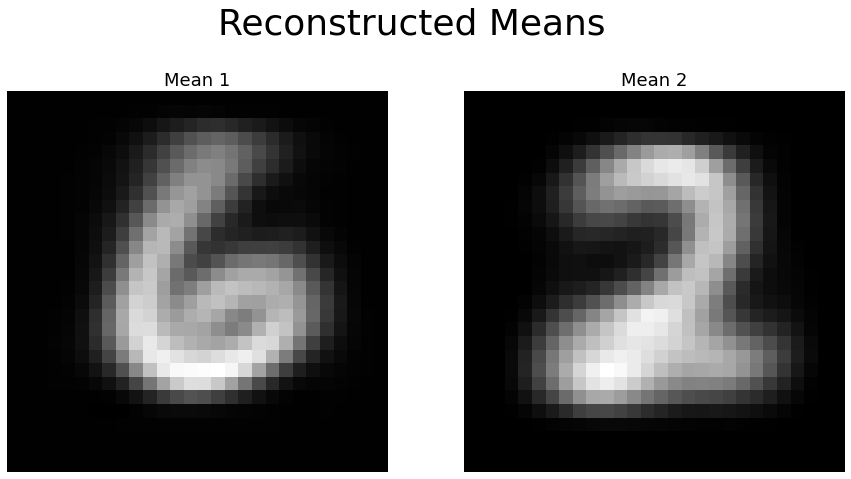

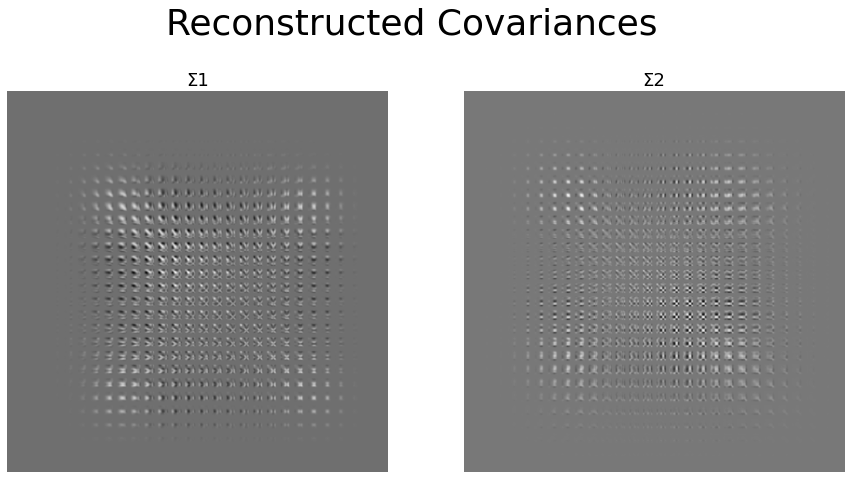

In [9]:
reconstruct_mus_and_sigmas(gmm.mus, gmm.covs, savefig1='means.png', savefig2='covs.png')

In [10]:
print('Cluster 1 Weight: {}\nCluster 2 Weight: {}'.format(*gmm.pis))

Cluster 1 Weight: 0.5068251510286222
Cluster 2 Weight: 0.49317484897137776


#### 5. Use the $\tau_k^i$ to infer the labels of the images, and compare with the true labels. Report the mis-classification rate for digits “2” and “6” respectively. Perform K-means clustering with K = 2 (you may call a package or use the code from your previous homework). Find out the mis-classification rate for digits “2” and “6” respectively, and compare with GMM. Which one achieves the better performance?

In [11]:
#classsify each observation based off of probability
classes = np.argmax(gmm.tau, axis=1)

In [12]:
#Extract which class each cluster's ground truth is
vals1, counts1 = np.unique(labels[classes==0], return_counts=True)
vals2, counts2 = np.unique(labels[classes==1], return_counts=True)

print('Cluster 1:    image {}:{} points    image {}:{} points'.format(vals1[0],counts1[0],
                                                                      vals1[1],counts1[1]))
print('Cluster 1 ==> Image {}'.format(vals1[np.argmax(counts1)]))

print()
print('Cluster 2:    image {}:{} points    image {}:{} points'.format(vals2[0],counts2[0],
                                                                      vals2[1],counts2[1]))
print('Cluster 2 ==> Image {}'.format(vals2[np.argmax(counts2)]))

Cluster 1:    image 2:60 points    image 6:951 points
Cluster 1 ==> Image 6

Cluster 2:    image 2:972 points    image 6:7 points
Cluster 2 ==> Image 2


In [13]:
def misclassification_rate(counts):
    total = np.sum(counts)
    wrong = np.min(counts)
    
    return wrong / total

In [14]:
print('Cluster 1 (image 6) Misclassification: {}'.format(misclassification_rate(counts1)))
print('Cluster 2 (image 2) Misclassification: {}'.format(misclassification_rate(counts2)))

Cluster 1 (image 6) Misclassification: 0.05934718100890208
Cluster 2 (image 2) Misclassification: 0.007150153217568948


In [15]:
print('Total Misclassification: {}'.format((60+7) / (60+7+972+951)))
print('Misclassification of 2s: {}'.format(60 / (60+972)))
print('Missclassifcation of 6s: {}'.format(7 / (951 + 7)))

Total Misclassification: 0.033668341708542715
Misclassification of 2s: 0.05813953488372093
Missclassifcation of 6s: 0.007306889352818371


##### KMeans Implementation

In [16]:
clf = KMeans(n_clusters=2)
clf.fit(data_pca)

classes = clf.labels_

In [17]:
#Extract which class each cluster's ground truth is
vals1, counts1 = np.unique(labels[classes==0], return_counts=True)
vals2, counts2 = np.unique(labels[classes==1], return_counts=True)

print('Cluster 1:    image {}:{} points    image {}:{} points'.format(vals1[0],counts1[0],
                                                                      vals1[1],counts1[1]))
print('Cluster 1 ==> Image {}'.format(vals1[np.argmax(counts1)]))

print()
print('Cluster 2:    image {}:{} points    image {}:{} points'.format(vals2[0],counts2[0],
                                                                      vals2[1],counts2[1]))
print('Cluster 2 ==> Image {}'.format(vals2[np.argmax(counts2)]))

Cluster 1:    image 2:79 points    image 6:915 points
Cluster 1 ==> Image 6

Cluster 2:    image 2:953 points    image 6:43 points
Cluster 2 ==> Image 2


In [18]:
print('Cluster 1 (image 6) Misclassification: {}'.format(misclassification_rate(counts1)))
print('Cluster 2 (image 2) Misclassification: {}'.format(misclassification_rate(counts2)))

Cluster 1 (image 6) Misclassification: 0.079476861167002
Cluster 2 (image 2) Misclassification: 0.04317269076305221


In [19]:
print('Total Misclassification: {}'.format((79+43) / (79+43+915+953)))
print('Misclassification of 2s: {}'.format(79 / (79+953)))
print('Missclassifcation of 6s: {}'.format(43 / (915 + 43)))

Total Misclassification: 0.061306532663316586
Misclassification of 2s: 0.07655038759689922
Missclassifcation of 6s: 0.04488517745302714
